In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
from random import random
from sklearn.model_selection import cross_validate

In [3]:
file = uproot.open('/home/andy/12360.root')
file2 = uproot.open('/home/andy/12362.root')

In [4]:
def make_equal(x,length):
    x_len = len(x)
    while len(x) < length:
        x = np.append(x,[0])
    return x

In [5]:
energy1 = np.log10(file['MCPrimary']['energy'].array())
time1 = file['All_pulses']['time'].array()
charge1 = file['All_pulses']['charge'].array()
S125_1 = np.log10(file['LaputopParams']['s125'].array())
zenith1 = file['MCPrimary']['zenith'].array()
radius1 = file['All_radius']['item'].array()
mass1 = []
for i in range(len(zenith1)):
    mass1.append(1)
    
new_charge1 = []
for i,j in zip(radius1,charge1):
    check = zip(i,j)
    new_charge1.append(np.array(list(zip(*sorted(check, key = lambda x: x[0])))[1]))
charge1 = np.array(new_charge1)

new_time1 = []
for i,j in zip(radius1,time1):
    check = zip(i,j)
    new_time1.append(abs(np.array(list(zip(*sorted(check, key = lambda x: x[0])))[1])))
time1 = np.array(new_time1)

energy2 = np.log10(file2['MCPrimary']['energy'].array())
time2 = file2['All_pulses']['time'].array()
charge2 = file2['All_pulses']['charge'].array()
S125_2 = np.log10(file2['LaputopParams']['s125'].array())
zenith2 = file2['MCPrimary']['zenith'].array()
radius2 = file2['All_radius']['item'].array()


new_charge2 = []
for i,j in zip(radius2,charge2):
    check = zip(i,j)
    new_charge2.append(np.array(list(zip(*sorted(check, key = lambda x: x[0])))[1]))
charge2 = np.array(new_charge2)

new_time2 = []
for i,j in zip(radius2,time2):
    check = zip(i,j)
    new_time2.append(abs(np.array(list(zip(*sorted(check, key = lambda x: x[0])))[1])))
time2 = np.array(new_time2)

mass2 = []
for i in range(len(zenith2)):
    mass2.append(4)
    
energy = np.append(energy1,energy2)

charge1 = np.array([np.log10(i[i>0]) for i in charge1])

charge2 = np.array([np.log10(i[i>0]) for i in charge2])

S125 = np.append(S125_1,S125_2)

zenith = np.append(zenith1,zenith2)

radius = np.append(radius1,radius2)

mass = np.append(mass1,mass2)


charge = np.append(charge1,charge2)   
time = np.append(time1,time2)
data = [np.append(i,j) for i,j in zip(energy,zenith)]
data = [np.append(i,j) for i,j in zip(data,mass)]

KeyboardInterrupt: 

In [ ]:
new_time = [make_equal(i,162) for i in time]
new_charge= [make_equal(i,162) for i in charge]
#new_radius = [make_equal(i,162) for i in radius]

In [ ]:
input_variable = [np.append(i,j) for i,j in zip(new_time,new_charge)]
input_variable = [np.append(i,[j]) for i,j in zip(input_variable,S125)]
#input_variable = [np.append(i,j) for i,j in zip(input_variable,new_radius)]

In [ ]:
np.save('All_data_preprocessed_new',{'input':input_variable,'data':data})

In [ ]:
from sklearn.model_selection import train_test_split
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(input_variable, np.array(data), test_size=test_size, random_state=seed)

In [9]:
np.save('All_data_new',{'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test})

In [2]:
new_import = np.load('All_data_new.npy',allow_pickle=True,encoding='latin1').item()
X_train = new_import['X_train']
X_test = new_import['X_test']
y_train = new_import['y_train']
y_test = new_import['y_test']

In [4]:
rng = np.random.RandomState(1)
regr_1 = MultiOutputRegressor(AdaBoostRegressor(DecisionTreeRegressor(max_depth=12,criterion='friedman_mse'),
                                n_estimators=70, random_state=rng,loss='square'))

regr_1.fit(X_train,y_train)
y_1= regr_1.predict(X_test)
mse = [(i-j)**2.0 for i,j in zip(y_1,y_test)]
mean = [np.mean(i) for i in list(zip(*mse))]
print(mean)

[0.01761818054647885, 0.0034502527279301463, 2.240005692049457]


In [18]:
energy_predicted = np.array(list(zip(*y_1))[0])
zenith_predicted = np.array(list(zip(*y_1))[1])
mass_predicted = np.array(list(zip(*y_1))[2])


energy_true = np.array(list(zip(*y_test))[0])
zenith_true = np.array(list(zip(*y_test))[1])
mass_true = np.array(list(zip(*y_test))[2])

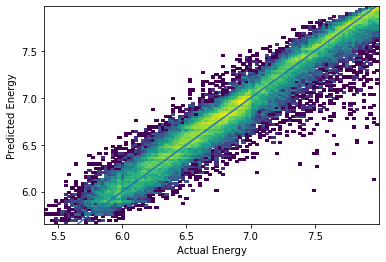

In [19]:
import matplotlib
x = np.linspace(min(energy_true),max(energy_true),1000)
plt.plot(x,x,)
plt.hist2d(energy_true,energy_predicted,bins=100,norm=matplotlib.colors.LogNorm())
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.savefig('Energy_predictions2')

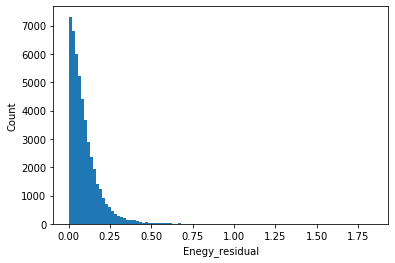

In [20]:
residual = [abs(i-j) for i,j in zip(energy_true,energy_predicted)]
plt.hist(residual,bins=100)
plt.xlabel('Enegy_residual')
plt.ylabel('Count')
plt.savefig('energy_residuals')

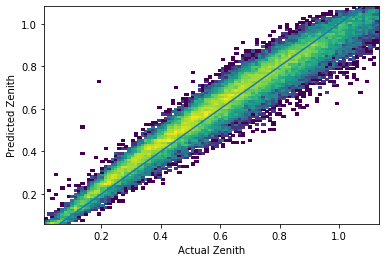

In [21]:
x = np.linspace(min(zenith_true),max(zenith_true),1000)
plt.plot(x,x,)
plt.hist2d(zenith_true,zenith_predicted,bins=100,norm=matplotlib.colors.LogNorm())
plt.xlabel('Actual Zenith')
plt.ylabel('Predicted Zenith')
plt.savefig('Zenith_predictions2')

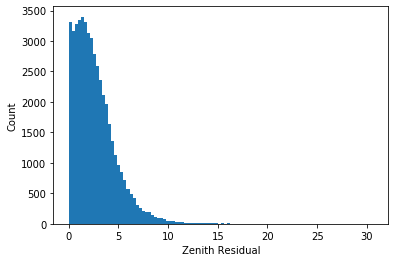

In [22]:
residual = [abs(i-j)*180/np.pi for i,j in zip(zenith_true,zenith_predicted)]
plt.hist(residual,bins=100)
plt.xlabel('Zenith Residual')
plt.ylabel('Count')
plt.savefig('zenith_residuals')

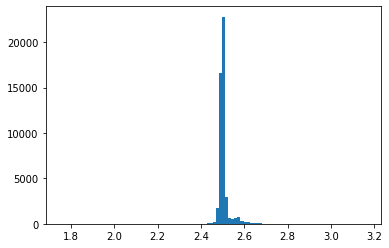

In [23]:
plt.hist(mass_predicted,bins=100)
plt.show()

In [24]:
mass_predicted_new = []
for i in mass_predicted:
    if i <= 1.5:
        mass_predicted_new.append(1)
    elif i >= 3.5:
        mass_predicted_new.append(4)
    else:
        mass_predicted_new.append(0)

In [25]:
count = 0
for i,j in zip(mass_true,mass_predicted_new):
    if i==j:
        count+=1
print(count/len(mass_true))

0.0


In [26]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(mass_true,mass_predicted_new))
cm = confusion_matrix(mass_true,mass_predicted_new)

[[    0     0     0]
 [26015     0     0]
 [22029     0     0]]


In [27]:
import pickle
pickle.dump(regr_1, open('fifth_model.sav', 'wb'))